In [1]:
%matplotlib inline
import os
import random
import multiprocessing

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
import tensorflow as tf

from sklearn.model_selection import train_test_split
import sklearn.metrics
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

from urllib.parse import urlparse
from urllib.request import urlretrieve

In [2]:
#Set seeds 
SEED = 42
def set_seeds(seed=SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
def set_global_determinism(seed=SEED):
    set_seeds(seed=seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    tf.config.threading.set_inter_op_parallelism_threads(multiprocessing.cpu_count())
    tf.config.threading.set_intra_op_parallelism_threads(multiprocessing.cpu_count())

set_global_determinism(seed=SEED)

In [3]:
def load_data(url, **kwargs):
    path = urlparse(url).path
    filename = os.path.basename(path)
    if not os.path.exists(filename):
        urlretrieve(url, filename)
    return pd.read_csv(filename, **kwargs)

In [4]:
data = load_data('https://github.com/hse-aml/hadron-collider-machine-learning/releases/download/Week_2/training.csv.gz')

In [5]:
data.head()

,TrackP,TrackNDoFSubdetector2,BremDLLbeElectron,MuonLooseFlag,FlagSpd,SpdE,EcalDLLbeElectron,DLLmuon,RICHpFlagElectron,EcalDLLbeMuon,...,TrackNDoF,RICHpFlagMuon,RICH_DLLbeKaon,RICH_DLLbeElectron,HcalE,MuonFlag,FlagMuon,PrsE,RICH_DLLbeMuon,RICH_DLLbeProton
0,74791.156263,15.0,0.232275,1.0,1.0,3.2,-2.505719,6.604153,1.0,1.929960,...,28.0,1.0,-7.213300,-0.280200,5586.589846,1.0,1.0,10.422315,-2.081143e-07,-24.824400
1,2738.489989,15.0,-0.357748,0.0,1.0,3.2,1.864351,0.263651,1.0,-2.061959,...,32.0,1.0,-0.324317,1.707283,-0.000007,0.0,1.0,43.334935,2.771583e+00,-0.648017
2,2161.409908,17.0,-999.000000,0.0,0.0,-999.0,-999.000000,-999.000000,0.0,-999.000000,...,27.0,0.0,-999.000000,-999.000000,-999.000000,0.0,0.0,-999.000000,-9.990000e+02,-999.000000
3,15277.730490,20.0,-0.638984,0.0,1.0,3.2,-2.533918,-8.724949,1.0,-3.253981,...,36.0,1.0,-35.202221,-14.742319,4482.803707,0.0,1.0,2.194175,-3.070819e+00,-29.291519
4,7563.700195,19.0,-0.638962,0.0,1.0,3.2,-2.087146,-7.060422,1.0,-0.995816,...,33.0,1.0,25.084287,-10.272412,5107.554680,0.0,1.0,0.000015,-5.373712e+00,23.653087


In this programming assignment you will train a classifier to identify type of a particle. There are six particle types: electron, proton, muon, kaon, pion and ghost. Ghost is a particle with other type than the first five or a detector noise. 

Different particle types remain different responses in the detector systems or subdetectors. Thre are five systems: tracking system, ring imaging Cherenkov detector (RICH), electromagnetic and hadron calorimeters, and muon system.

![pid](pid.jpg)

![scheme](scheme.png)

### List of columns in the samples

Here, **Spd** stands for Scintillating Pad Detector, **Prs** - Preshower, **Ecal** - electromagnetic calorimeter, **Hcal** - hadronic calorimeter, **Brem** denotes traces of the particles that were deflected by detector.

- ID - id value for tracks (presents only in the test file for the submitting purposes)
- Label - string valued observable denoting particle types. Can take values "Electron", "Muon", "Kaon", "Proton", "Pion" and "Ghost". This column is absent in the test file.
- FlagSpd - flag (0 or 1), if reconstructed track passes through Spd
- FlagPrs - flag (0 or 1), if reconstructed track passes through Prs
- FlagBrem - flag (0 or 1), if reconstructed track passes through Brem
- FlagEcal - flag (0 or 1), if reconstructed track passes through Ecal
- FlagHcal - flag (0 or 1), if reconstructed track passes through Hcal
- FlagRICH1 - flag (0 or 1), if reconstructed track passes through the first RICH detector
- FlagRICH2 - flag (0 or 1), if reconstructed track passes through the second RICH detector
- FlagMuon - flag (0 or 1), if reconstructed track passes through muon stations (Muon)
- SpdE - energy deposit associated to the track in the Spd
- PrsE - energy deposit associated to the track in the Prs
- EcalE - energy deposit associated to the track in the Hcal
- HcalE - energy deposit associated to the track in the Hcal
- PrsDLLbeElectron - delta log-likelihood for a particle candidate to be electron using information from Prs
- BremDLLbeElectron - delta log-likelihood for a particle candidate to be electron using information from Brem
- TrackP - particle momentum
- TrackPt - particle transverse momentum
- TrackNDoFSubdetector1  - number of degrees of freedom for track fit using hits in the tracking sub-detector1
- TrackQualitySubdetector1 - chi2 quality of the track fit using hits in the tracking sub-detector1
- TrackNDoFSubdetector2 - number of degrees of freedom for track fit using hits in the tracking sub-detector2
- TrackQualitySubdetector2 - chi2 quality of the track fit using hits in the  tracking sub-detector2
- TrackNDoF - number of degrees of freedom for track fit using hits in all tracking sub-detectors
- TrackQualityPerNDoF - chi2 quality of the track fit per degree of freedom
- TrackDistanceToZ - distance between track and z-axis (beam axis)
- Calo2dFitQuality - quality of the 2d fit of the clusters in the calorimeter 
- Calo3dFitQuality - quality of the 3d fit in the calorimeter with assumption that particle was electron
- EcalDLLbeElectron - delta log-likelihood for a particle candidate to be electron using information from Ecal
- EcalDLLbeMuon - delta log-likelihood for a particle candidate to be muon using information from Ecal
- EcalShowerLongitudinalParameter - longitudinal parameter of Ecal shower
- HcalDLLbeElectron - delta log-likelihood for a particle candidate to be electron using information from Hcal
- HcalDLLbeMuon - delta log-likelihood for a particle candidate to be using information from Hcal
- RICHpFlagElectron - flag (0 or 1) if momentum is greater than threshold for electrons to produce Cherenkov light
- RICHpFlagProton - flag (0 or 1) if momentum is greater than threshold for protons to produce Cherenkov light
- RICHpFlagPion - flag (0 or 1) if momentum is greater than threshold for pions to produce Cherenkov light
- RICHpFlagKaon - flag (0 or 1) if momentum is greater than threshold for kaons to produce Cherenkov light
- RICHpFlagMuon - flag (0 or 1) if momentum is greater than threshold for muons to produce Cherenkov light
- RICH_DLLbeBCK  - delta log-likelihood for a particle candidate to be background using information from RICH
- RICH_DLLbeKaon - delta log-likelihood for a particle candidate to be kaon using information from RICH
- RICH_DLLbeElectron - delta log-likelihood for a particle candidate to be electron using information from RICH
- RICH_DLLbeMuon - delta log-likelihood for a particle candidate to be muon using information from RICH
- RICH_DLLbeProton - delta log-likelihood for a particle candidate to be proton using information from RICH
- MuonFlag - muon flag (is this track muon) which is determined from muon stations
- MuonLooseFlag muon flag (is this track muon) which is determined from muon stations using looser criteria
- MuonLLbeBCK - log-likelihood for a particle candidate to be not muon using information from muon stations
- MuonLLbeMuon - log-likelihood for a particle candidate to be muon using information from muon stations
- DLLelectron - delta log-likelihood for a particle candidate to be electron using information from all subdetectors
- DLLmuon - delta log-likelihood for a particle candidate to be muon using information from all subdetectors
- DLLkaon - delta log-likelihood for a particle candidate to be kaon using information from all subdetectors
- DLLproton - delta log-likelihood for a particle candidate to be proton using information from all subdetectors
- GhostProbability - probability for a particle candidate to be ghost track. This variable is an output of classification model used in the tracking algorithm.

Delta log-likelihood in the features descriptions means the difference between log-likelihood for the mass hypothesis that a given track is made by some particle (for example, electron) and log-likelihood for the mass hypothesis that a given track is produced by a pion (so, DLLpion = 0 and thus we don't have these columns). This is done since most tracks (~80%) are left by pions and in practice we actually need to discriminate other particles from pions. In other words, the null hypothesis is that particle is a pion.

![features](features.jpg)

In [6]:
le = preprocessing.LabelEncoder()
le.fit(data.Label)
y = le.transform(data.Label).astype(float)
labels = np.array(le.classes_, dtype=str)
labels

array(['Electron', 'Ghost', 'Kaon', 'Muon', 'Pion', 'Proton'], dtype='<U8')

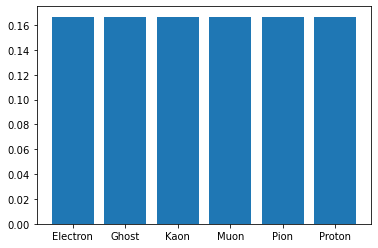

In [7]:
count = np.array([(data.Label == l).sum() for l in labels])
plt.figure()
plt.bar(np.arange(len(labels)), count / np.sum(count))
plt.xticks(np.arange(len(labels)), labels)
plt.show()

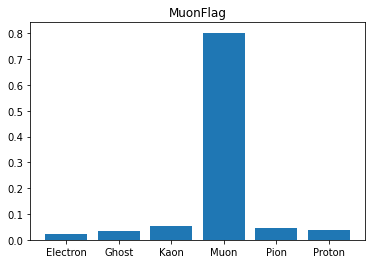

In [8]:
ratio = np.array([data[data.Label == l]["MuonFlag"].sum() for l in labels]) / count
plt.figure()
plt.title("MuonFlag")
plt.bar(np.arange(len(labels)), ratio)
plt.xticks(np.arange(len(labels)), labels)
plt.show()

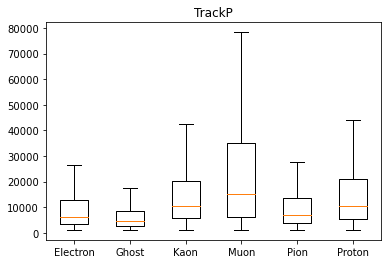

In [9]:
moment = list([data[data.Label == l]["TrackP"] for l in labels])
moment = list([x[x > -998] for x in moment])
plt.title("TrackP")
plt.boxplot(moment, showfliers=False)
plt.xticks(np.arange(len(labels))+1, labels)
plt.show()

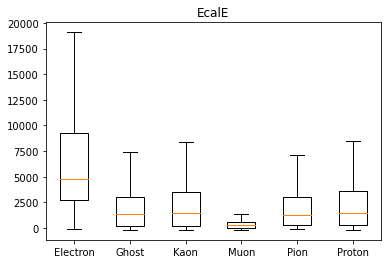

In [10]:
energy = list([data[data.Label == l]["EcalE"] for l in labels])
energy = list([x[x > -998] for x in energy])
plt.figure()
plt.title("EcalE")
plt.boxplot(energy, showfliers=False)
plt.xticks(np.arange(len(labels))+1, labels)
plt.show()

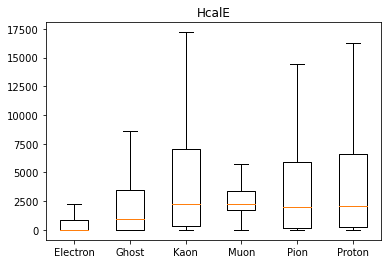

In [11]:
energy = list([data[data.Label == l]["HcalE"] for l in labels])
energy = list([x[x > -998] for x in energy])
plt.figure()
plt.title("HcalE")
plt.boxplot(energy, showfliers=False)
plt.xticks(np.arange(len(labels))+1, labels)
plt.show()

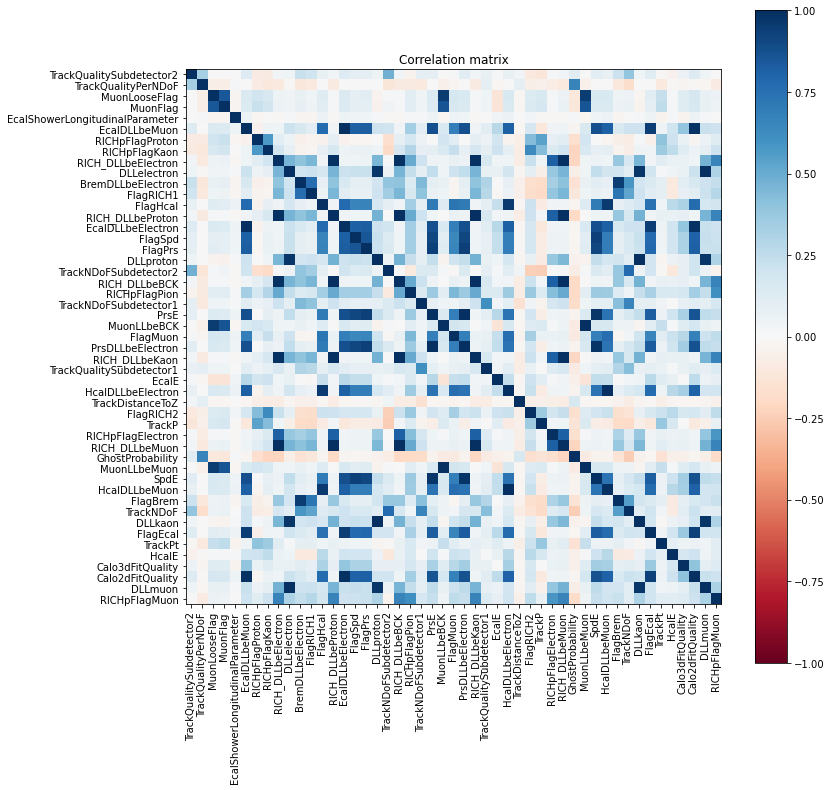

In [12]:
features = np.asarray(list(set(data.columns) - {'Label',}))

x = np.asarray(data[features])
x_cov = np.cov(x.T)
sigma = np.sqrt(np.diag(x_cov))
x_cor = x_cov / np.outer(sigma, sigma)

plt.figure(figsize=(12, 12))
vmax = 1.0
plt.imshow(x_cor, interpolation='nearest', vmin=-vmax, vmax=vmax, cmap=plt.cm.RdBu)
plt.title("Correlation matrix")
plt.colorbar()
plt.yticks(np.arange(len(features)), features)
plt.xticks(rotation=90)
_ = plt.xticks(np.arange(len(features)), features)

## Логистическая регрессия

In [13]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)

In [14]:
roc = {}
auc = {}
models = []
for l, label in enumerate(tqdm(labels)):
    one_y_train = np.asarray((y_train == l).astype(float))

    c = LogisticRegression(n_jobs=-1)
    c.fit(x_train, one_y_train.reshape(-1))
    models.append(c)

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [08:50<00:00, 88.38s/it]


In [15]:
for l, label in enumerate(tqdm(labels)):
    one_y_test = np.asarray((y_test == l).astype(float))
    c = models[l]

    y_pred = c.predict(x_test)
    scores = c.decision_function(x_test)

    fpr, tpr, _ = sklearn.metrics.roc_curve(one_y_test, scores)
    roc[l] = {"tpr": tpr, "fpr": fpr}
    auc[l] = sklearn.metrics.roc_auc_score(one_y_test, scores)

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  5.48it/s]


### График ROC

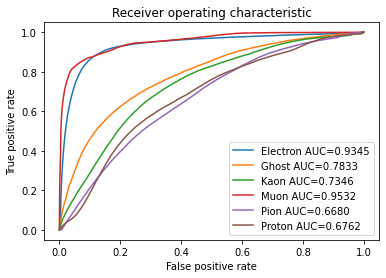

In [16]:
plt.figure()
plt.title("Receiver operating characteristic")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
for l, label in enumerate(labels):
    plt.plot(roc[l]['fpr'], roc[l]['tpr'], label='{} AUC={:.4f}'.format(label, auc[l]))
_ = plt.legend(loc='lower right')

### Распределение скоров для настоящих классов

Пример не очень хорошего классификатора. Распределения двух классов перекрываются по горизонтальной оси.

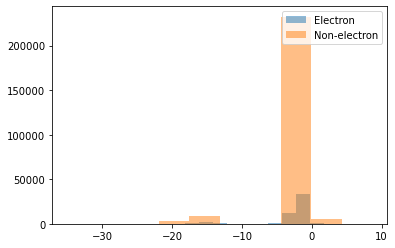

In [17]:
с = models[0]
scores = c.decision_function(x_test)
plt.hist(scores[y_test == 0], label='Electron', alpha=0.5)
plt.hist(scores[y_test != 0], label='Non-electron', alpha=0.5)
plt.legend(loc='upper right')

## Нейросети

In [79]:
try:
    model = tf.keras.models.load_model('NN_model/model')
    #Я понятия не имею почему, но строчка сверху выгружает нечто с рок аук 0.5-0.6, поэтому
    #Если запускать, то прошу убить эту строчку с try и очень долго ждать :) 
    model.load_weights('NN_model/weights.hdf5')
except:
    INPUT_DIM  = x_train.shape[1]
    HIDDEN_DIM = 5120
    OUTPUT_DIM = len(labels)

    model = tf.keras.Sequential([
        tf.keras.layers.Dense(HIDDEN_DIM, activation="sigmoid"),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(HIDDEN_DIM/2, activation="sigmoid"),
        tf.keras.layers.Dropout(0.05),
        tf.keras.layers.Dense(HIDDEN_DIM/4, activation="sigmoid"),
        tf.keras.layers.Dropout(0.05),
        tf.keras.layers.Dense(HIDDEN_DIM/8, activation="sigmoid"),
        tf.keras.layers.Dropout(0.05),
        tf.keras.layers.Dense(OUTPUT_DIM, activation="softmax"),
    ])

    learning_rate = 1e-4
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss='categorical_crossentropy',
              metrics=[
                  'accuracy',
                  tf.keras.metrics.AUC()
              ])
    checkpoint = tf.keras.callbacks.ModelCheckpoint("NN_model/weights.hdf5",
                                     monitor="val_loss",
                                    save_best_only=True)
    history = model.fit(x_train, tf.keras.utils.to_categorical(y_train, num_classes=len(labels)),
          epochs=20, batch_size=384, callbacks=[checkpoint, tf.keras.callbacks.TerminateOnNaN(),
                                              tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=20)],
          validation_data=(x_test, tf.keras.utils.to_categorical(y_test, num_classes=len(labels)))
         )
    model.save('NN_model/model')

Epoch 1/20
2344/2344 [==============================] - 377s 160ms/step - loss: 1.0738 - accuracy: 0.5405 - auc_16: 0.8805 - val_loss: 0.9214 - val_accuracy: 0.5957 - val_auc_16: 0.9127
Epoch 2/20
2344/2344 [==============================] - 375s 160ms/step - loss: 0.9240 - accuracy: 0.5970 - auc_16: 0.9120 - val_loss: 0.9000 - val_accuracy: 0.6056 - val_auc_16: 0.9164
Epoch 3/20
2344/2344 [==============================] - 375s 160ms/step - loss: 0.9015 - accuracy: 0.6073 - auc_16: 0.9161 - val_loss: 0.8736 - val_accuracy: 0.6212 - val_auc_16: 0.9213
Epoch 4/20
2344/2344 [==============================] - 375s 160ms/step - loss: 0.8869 - accuracy: 0.6153 - auc_16: 0.9188 - val_loss: 0.8652 - val_accuracy: 0.6273 - val_auc_16: 0.9231
Epoch 5/20
2344/2344 [==============================] - 376s 160ms/step - loss: 0.8746 - accuracy: 0.6243 - auc_16: 0.9212 - val_loss: 0.8601 - val_accuracy: 0.6309 - val_auc_16: 0.9239
Epoch 6/20
2344/2344 [==============================] - 376s 160ms/ste

In [80]:
scores = model.predict(x_test)

roc = {}
auc = {}
for l, label in enumerate(labels):
    lscores = scores[:,l]
    one_y_test = np.asarray((y_test == l).astype(float))
    
    fpr, tpr, _ = sklearn.metrics.roc_curve(one_y_test, lscores)
    roc[l] = {"tpr": tpr, "fpr": fpr}
    auc[l] = sklearn.metrics.roc_auc_score(one_y_test, lscores)

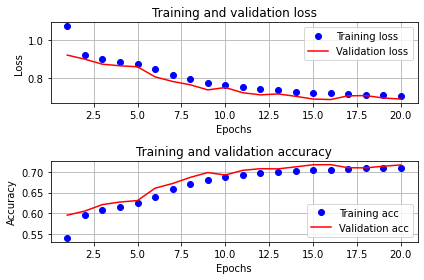

In [81]:
def plotting(history):
    ac = []
    for i in history.history.keys():
        ac.append(i)
    loss = history.history[ac[0]]
    val_loss = history.history[ac[3]]
    acc = history.history[ac[1]]
    val_acc = history.history[ac[4]]
    epochs = range(1, len(loss) + 1)
    fig = plt.figure()
    ax1 = fig.add_subplot(2, 1, 1)
    ax2 = fig.add_subplot(2, 1, 2)
    ax1.plot(epochs, loss, 'bo', label='Training loss')
    ax1.plot(epochs, val_loss, 'b', label='Validation loss', color='r')
    ax1.set_title('Training and validation loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax2.plot(epochs, acc, 'bo', label='Training acc')
    ax2.plot(epochs, val_acc, 'b', label='Validation acc', color='r')
    ax2.set_title('Training and validation accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    for ax in fig.axes:
        ax.grid(True)
    plt.tight_layout()
    plt.show()
plotting(history)

### График ROC

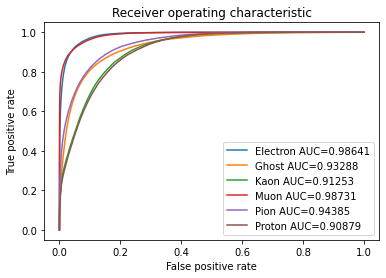

In [82]:
plt.figure()
plt.title("Receiver operating characteristic")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
for l, label in enumerate(labels):
    plt.plot(roc[l]['fpr'], roc[l]['tpr'], label='{} AUC={:.5f}'.format(label, auc[l]))
_ = plt.legend(loc='lower right')

0.98641 лучший

### Распределение скоров для настоящих классов

Видно, что электроны кучкуются в правой части графика, а не электроны кучкуются в левой части. Уже лучше, но в середине они все-равно перекрываются.

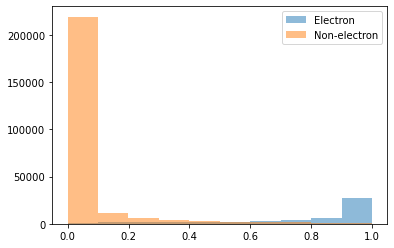

In [36]:
plt.hist(scores[y_test == 0, 0], label='Electron', alpha=0.5)
plt.hist(scores[y_test != 0, 0], label='Non-electron', alpha=0.5)
plt.legend(loc='upper right')

### Матрица ошибок

Видно, например, что каоны путаются с протонами.

              precision    recall  f1-score   support

    Electron       0.80      0.85      0.83     49983
       Ghost       0.52      0.43      0.47     49964
        Kaon       0.47      0.36      0.41     49901
        Muon       0.85      0.85      0.85     50344
        Pion       0.58      0.73      0.65     49894
      Proton       0.44      0.48      0.46     49914

    accuracy                           0.62    300000
   macro avg       0.61      0.62      0.61    300000
weighted avg       0.61      0.62      0.61    300000



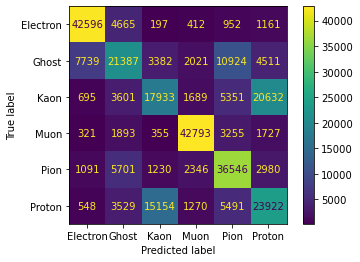

In [23]:
y_true = y_test
y_pred = model.predict(x_test).argmax(axis=1)

print(classification_report(y_true, y_pred, target_names=labels))

cm = confusion_matrix(y_true, y_pred)

cmd = ConfusionMatrixDisplay(cm, display_labels=labels)
_ = cmd.plot()